In [21]:
import matplotlib.pyplot as plt
from PIL import Image, ImageSequence
import torch
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
# Path to our video (or gif, which is also a sequence of images)
gif_path = "thats-it-yes-thats-it.gif"
# Transform to convert PIL images to tensors
to_tensor = T.ToTensor()
# Load GIF image
gif = Image.open(gif_path)

frames = []
for frame in ImageSequence.Iterator(gif):
    # ensure 3 channels
    frame = frame.convert("RGB")
    frame_tensor = to_tensor(frame)
    frames.append(frame_tensor)

# Stack frames along time dimension
# tensor of size (20 frames, 3 channels RGB, 220pixels, 220 pixels)
video = torch.stack(frames, dim=0)   
print(video.shape)

torch.Size([20, 3, 220, 220])


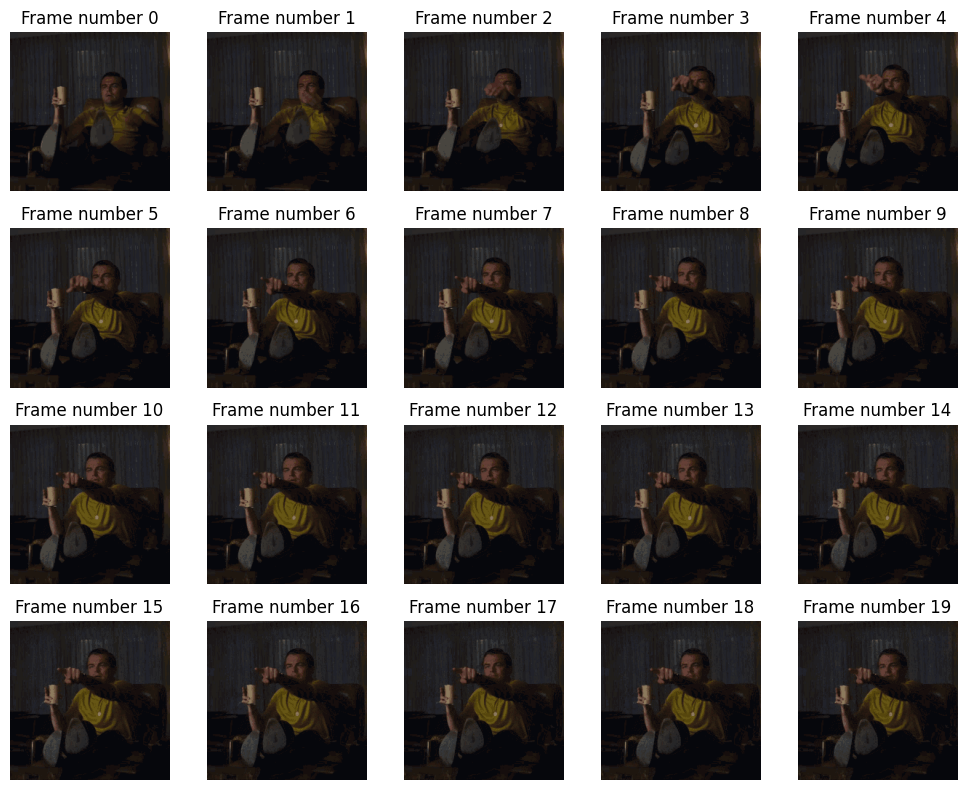

In [23]:
#  Display our 20 frames
num_frames = video.shape[0]
fig, axes = plt.subplots(4, 5, figsize = (10, 8))
axes = axes.flatten()

# Load all images, frame by frame
for i in range(num_frames):
    # need to reorganize the dimensions into (H, W, C) for matplotlib
    frame = video[i].permute(1, 2, 0)  
    axes[i].imshow(frame)
    axes[i].set_title(f"Frame number {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [37]:
class CNN(nn.Module):
    """
    Frame encoder: (C,H,W) -> (D,)
    A few Conv2d layers then flatten then a Linear.
    """
    def __init__(self, in_channels=3, feat_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size = 5, stride = 2, padding = 2)  # -> (16, H/2, W/2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2, padding = 1)          # -> (32, H/4, W/4)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1)          # -> (64, H/8, W/8)
        self.fc = nn.Linear(50176, feat_dim)

    def forward(self, frame_batch):
        """
        frame_batch: (B, C, H, W)
        returns: (B, D)
        """
        x = F.relu(self.conv1(frame_batch))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Flatten
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [38]:
# Extract the first frame of the GIF
# and resize it as a tensor of size (1, 3, 220, 220)
frame = video[0, :, :, :].unsqueeze(0)
print("Single frame as tensor:", frame.size())

# Pass image through our CNN
cnn_model = CNN()
output = cnn_model(frame)
print("Output from CNN for a single frame:", output.size())

Single frame as tensor: torch.Size([1, 3, 220, 220])
Output from CNN for a single frame: torch.Size([1, 128])


In [48]:
class ManualRNNVideoClassifier(nn.Module):
    """
    Manual recurrent loop:
    - Encode each frame with CNN -> x_t (D)
    - Recurrent update -> h_t (H)
    - Final classification from h_T
    """
    def __init__(self, num_classes=5, feat_dim=128, hidden_dim=64):
        super().__init__()
        # Reuse our CNN to process each frame independently
        self.cnn = CNN(in_channels=3, feat_dim=feat_dim)

        # Manual RNN parameters (simpler LSTM)
        self.Wx = nn.Linear(feat_dim, hidden_dim)
        self.Wh = nn.Linear(hidden_dim, hidden_dim)
        self.final = nn.Linear(hidden_dim, num_classes)

    def forward(self, video):
        """
        video: (T, C, H, W)
        returns: logits (B, num_classes)
        """
        # Extract video parameters (dimensions, channels, number of frames)
        T, C, H, W = video.shape
        # Resize video for CNN (So frames will be (1, 3, 220, 220))
        video = video.unsqueeze(0)
        B = 1
        # Initialize memory vector as zeroes
        h = torch.zeros(B, self.Wh.in_features, device=video.device)
        # Process frames sequentially
        for t in range(T):
            # Extract frame as tensor (B, C, H, W)
            frame_t = video[:, t]
            # Process frame with CNN, get output x_t from CNN
            x_t = self.cnn(frame_t)
            # Update memory simply, following the idea of gating mechanisms in LSTM
            h = torch.tanh(self.Wx(x_t) + self.Wh(h))
        # Use the final hidden state, pass it through a final linear layer and use the result as final output!
        y = self.final(h)
        return y

In [49]:
# Create our model
rnn_model = ManualRNNVideoClassifier(num_classes = 5, feat_dim = 128, hidden_dim = 64)
result = rnn_model(video)  # video is (T, C, H, W)
print("Result from RNN of CNN as tensor of size (1, num_classes):", result.shape)

Result from RNN of CNN as tensor of size (1, num_classes): torch.Size([1, 5])


In [51]:
class LSTMVideoClassifier(nn.Module):
    """
    Manual recurrent loop:
    - Encode each frame with CNN -> x_t (D)
    - Recurrent update -> h_t (H)
    - Final classification from h_T
    """
    def __init__(self, num_classes=5, feat_dim=128, hidden_dim=64):
        super().__init__()
        # Reuse our CNN to process each frame independently
        self.cnn = CNN(in_channels=3, feat_dim=feat_dim)

        # Now using the LSTM built-in function from PyTorch!
        self.lstm = nn.LSTM(input_size=feat_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)

        # As before, final layer
        self.final = nn.Linear(hidden_dim, num_classes)

    def forward(self, video):
        """
        video: (T, C, H, W)
        returns: logits (B=1, num_classes)
        """
        # Extract video parameters (dimensions, channels, number of frames)
        T, C, H, W = video.shape
        # Resize video for CNN (So frames will be (1, 3, 220, 220))
        video = video.unsqueeze(0)
        B = 1

        # Initialize two memory vector as zeroes
        h = torch.zeros(1, B, self.lstm.hidden_size, device=video.device)
        c = torch.zeros(1, B, self.lstm.hidden_size, device=video.device)

        # Process frames sequentially
        for t in range(T):
            # Extract frame as tensor (B, C, H, W)
            frame_t = video[:, t]
            # Process frame with CNN, get output x_t from CNN
            x_t = self.cnn(frame_t)
            # Reshape x_t: LSTM expects (B, seq_len, feat_dim) because batch_first=True
            x_t = x_t.unsqueeze(1)
            # Update memory vectors, using our LSTM
            out, (h, c) = self.lstm(x_t, (h, c))

        # Use final hidden state from last timestep, pass through linear and get output
        last_h = h[-1]
        y = self.final(last_h)
        return y

In [52]:
# Create our model
lstm_model = LSTMVideoClassifier(num_classes = 5, feat_dim = 128, hidden_dim = 64)
result = lstm_model(video)  # video is (T, C, H, W)
print("Result from LSTM of CNN as tensor of size (1, num_classes):", result.shape)

Result from LSTM of CNN as tensor of size (1, num_classes): torch.Size([1, 5])
